## Practice Data

In [42]:
import os
import pandas as pd
import numpy as np

In [43]:
import tensorflow as tf, keras
from keras import layers
from keras.layers import StringLookup, IntegerLookup, Embedding, Normalization, Dense

In [44]:
path = os.path.normpath("practice_baseball_data.csv")

In [45]:
df = pd.read_csv(path)

def make_label(df) -> pd.Series:
    above_average_for_season = df.groupby(['Season'])['HR'].transform(np.mean)
    return (df.HR > above_average_for_season).astype(int)


def preprocess_data(df) -> pd.DataFrame:
    """Not really a part of practice. This is cleaning we would normally expect to be finished."""
    df = (
        df.rename(columns={"K%": "K", "BB%": "BB"})
        .assign(BB=lambda df: df['BB'].str.replace('%', ""), K=lambda df: df['K'].str.replace('%', ""))
        .astype({"BB": 'float', 'K': 'float'})
        .drop(columns=['xwOBA'])
    )
    df = df.merge(df.assign(Season=lambda df: df.Season + 1, label=make_label)[['Season', 'playerid','label']], on=['Season', 'playerid'], how='left').dropna()
    df.label = df.label.astype(int)
    return df

df = preprocess_data(df)
# df = df.drop(columns=['Name', "Team"])
selected = ['label'] + ["Season", "HR", "K", "BB", "PA", "Team"]
df = df[selected]
df.dtypes
#df.label.astype(int, inplace=True)

C:\Users\lenha\AppData\Local\Temp\ipykernel_2036\114222278.py:4: FutureWarning: The provided callable <function mean at 0x000002207FB687C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  above_average_for_season = df.groupby(['Season'])['HR'].transform(np.mean)


label       int32
Season      int64
HR          int64
K         float64
BB        float64
PA          int64
Team       object
dtype: object

In [46]:
df.isna().sum()

label     0
Season    0
HR        0
K         0
BB        0
PA        0
Team      0
dtype: int64

## Practice Code

In [47]:
def dataframe_to_dataset(df: pd.DataFrame, batch_size: int = 512, shuffle: bool = True) -> tf.data.Dataset:
    df = df.copy()
    label = df.pop('label')  # TODO: no hardcoded values.
    _df: dict = {col: df[col].values[:, tf.newaxis] for col in df}
    ds = tf.data.Dataset.from_tensor_slices((dict(_df), label))
    if shuffle:
        ds = ds.shuffle(len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def extract_feature_ds(data: tf.data.Dataset, name: str) -> tf.data.Dataset:
    feature_ds = data.map(lambda x, y: x[name])
    dtype = feature_ds.element_spec.dtype
    return feature_ds, dtype

def make_embedding(data: tf.data.Dataset, name):
    feature_ds, dtype = extract_feature_ds(data, name)
    if dtype == tf.string:
        lookup = StringLookup()
    else:
        lookup = IntegerLookup()
    lookup.adapt(feature_ds)
    in_dims = len(lookup.get_vocabulary())
    out_dims = max(2, int(np.log(in_dims)))
    return lambda x: Embedding(in_dims, out_dims)(lookup(x))

def make_normalization(data: tf.data.Dataset, name: str) -> Normalization:
    feature_ds, dtype = extract_feature_ds(data, name)
    lookup = Normalization()
    lookup.adapt(feature_ds)
    return lookup

def make_inputs_and_encoded_features(data: tf.data.Dataset, cat_features) -> tuple[list, dict]:
    all_features = {}
    all_inputs = []
    for name, spec in data.element_spec[0].items():
        _input = keras.Input((1,), dtype=spec.dtype, name=name)
        if name in cat_features:
            encoder = make_embedding(data, name)
        else:
            encoder = make_normalization(data, name)
        all_features[name] = encoder(_input)
        all_inputs.append(_input)
    return all_inputs, all_features


In [48]:
from sklearn.model_selection import train_test_split
train, holdout = train_test_split(df, test_size=.2, random_state=42)
val, test = train_test_split(holdout, test_size=.5, random_state=42)
print(len(val), len(train))
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val, shuffle=False)
test_ds = dataframe_to_dataset(test, shuffle=False)

cat_features = ['Season', 'Team']

2103 16821


In [49]:
all_inputs, all_features = make_inputs_and_encoded_features(train_ds, cat_features)

In [50]:
def build_topology(all_features, cat_features):
    embedded = [keras.layers.Flatten()(all_features[feature]) for feature in cat_features]
    numeric = [all_features[feature] for feature in all_features if feature not in cat_features]
    x = keras.layers.Concatenate()(numeric + embedded)
    x = Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(.03)(x)
    x = Dense(1, activation='sigmoid')(x)
    return x

model = keras.Model(all_inputs, build_topology(all_features, cat_features))
metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=.003), loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=metrics)


In [54]:
callbacks = [keras.callbacks.EarlyStopping(patience=6, min_delta=.001, start_from_epoch=10)]
history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_6: 0.8314 - binary_accuracy: 0.7612 - loss: 0.5058 - precision_6: 0.7670 - recall_6: 0.6728 - val_auc_6: 0.8385 - val_binary_accuracy: 0.7680 - val_loss: 0.4968 - val_precision_6: 0.7760 - val_recall_6: 0.7029
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_6: 0.8313 - binary_accuracy: 0.7603 - loss: 0.5052 - precision_6: 0.7588 - recall_6: 0.6802 - val_auc_6: 0.8391 - val_binary_accuracy: 0.7632 - val_loss: 0.4982 - val_precision_6: 0.7873 - val_recall_6: 0.6711
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_6: 0.8349 - binary_accuracy: 0.7610 - loss: 0.5026 - precision_6: 0.7675 - recall_6: 0.6753 - val_auc_6: 0.8400 - val_binary_accuracy: 0.7675 - val_loss: 0.4958 - val_precision_6: 0.7733 - val_recall_6: 0.7059
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_6: 0.8393 - binary_accuracy: 0.7625 - loss: 0.4961 - precision_6: 0.7631 - recall_6: 0.6833 - val_auc_6: 0.8401 - val_binary_accuracy: 0.7699 

In [52]:
model.evaluate(train_ds)
print('va')
model.evaluate(val_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc_6: 0.8404 - binary_accuracy: 0.7587 - loss: 0.4990 - precision_6: 0.7804 - recall_6: 0.6451 
va
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_6: 0.8438 - binary_accuracy: 0.7673 - loss: 0.4938 - precision_6: 0.7961 - recall_6: 0.6734


[0.5013224482536316,
 0.7603423595428467,
 0.7920792102813721,
 0.6557376980781555,
 0.83780837059021]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


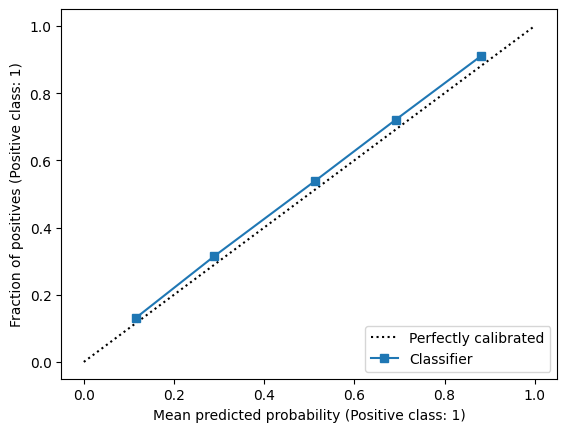

In [55]:
from sklearn.calibration import CalibrationDisplay

y_hat = model.predict(val_ds).reshape(-1)
y_true = val.label.values
CalibrationDisplay.from_predictions(y_true, y_hat)